In [1]:
from fastai import *
from fastai.vision import *
#from fastai.widgets import 
from torch.nn import CrossEntropyLoss

In [2]:
competition = 'datasciencebowl'

In [2]:
#!kaggle competitions download -c datasciencebowl -p {plankton_path}  
#!unzip {path}/sampleSubmission.csv.zip
#!unzip {path}/test.zip
#!unzip {path}/train.zip

In [3]:
plankton_path = Config.data_path()/'plankton'
train_path = plankton_path / 'train'
test_path = plankton_path / 'test'
project_path = pathlib.Path.home()/'PROJEX/competitions_1/plankton'

In [8]:
project_path.exists(), train_path.exists(), test_path.exists()

(True, True, True)

In [5]:
#df_sub = pd.read_csv(plankton_path/'sampleSubmission.csv')

In [27]:
#df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130400 entries, 0 to 130399
Columns: 122 entries, image to unknown_unclassified
dtypes: float64(121), object(1)
memory usage: 121.4+ MB


In [50]:
#df_sub.shape

(130400, 122)

In [7]:
#df_sub.head(1).T[1:].sum()

0    1.0
dtype: float64

It appears that the goal is to produce a csv file with 1 row per image, and columns populated by classes. For a given image, each class is assigned a probability. 

## Data Dealings

The training data set is partitioned into folders names after the classes they belonged to. The table above 122 classes.
The widget FileDeleter was removed in favor of ImageDeleter and ImageRelabeler.



In [6]:
test = ImageList.from_folder(test_path)
data = (ImageDataBunch.from_folder(train_path, train='./', valid_pct=0.2,
                                   ds_tfms=get_transforms(), size=224)
        .normalize(imagenet_stats))

In [7]:
data.classes[:5]

['acantharia_protist',
 'acantharia_protist_big_center',
 'acantharia_protist_halo',
 'amphipods',
 'appendicularian_fritillaridae']

In [13]:
#for c in data.classes:
#    verify_images(train_path/c, )

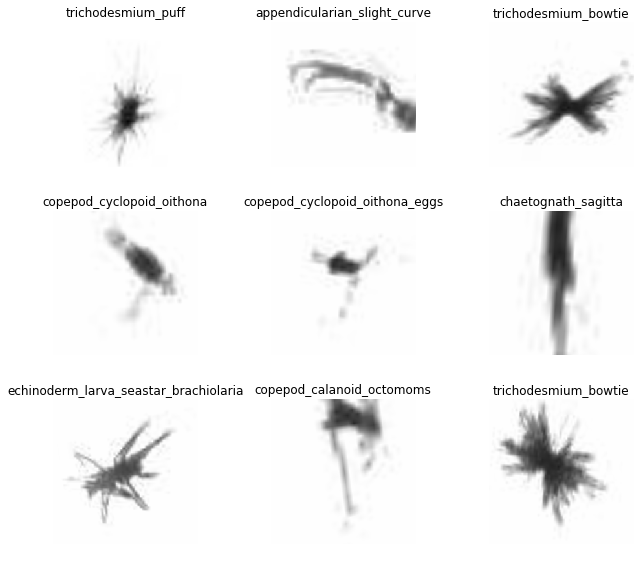

In [14]:
data.show_batch(rows=3, figsize=(9, 8))

In [9]:
data.c, len(data.train_ds), len(data.valid_ds)

(121, 24269, 6067)

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.loss_func = CrossEntropyLoss()

---
## TRAINING - PART 1
---

### Train model

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


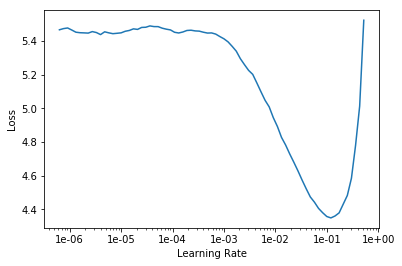

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.085551,1.554326,0.431844,01:56
1,1.625188,1.244018,0.365419,01:59
2,1.445843,1.111777,0.331795,01:59
3,1.322459,1.073278,0.324048,01:59


In [20]:
learn.save(project_path / 'stage-1')

In [21]:
stat = (project_path/'stage-1.pth').stat()

In [22]:
print(f'model size: {stat.st_size/int(1e6):.2f}MB')

model size: 92.50MB


---
## END OF TRAINING - PART 1
---

Now I'll give it a first shot with the test set see where that puts me in the leaderboard

In [12]:
test = ImageList.from_folder(test_path)
learn.load(project_path / 'stage-1');

In [42]:
learn.export(project_path/'export.pkl')

In [43]:
lexp = load_learner(project_path, test=test)

In [ ]:
images = [image.name for image in lexp.data.test_ds.items]

In [59]:
images[:5]

['80403.jpg', '92840.jpg', '137170.jpg', '36088.jpg', '102507.jpg']

In [46]:
preds, y = lexp.get_preds(ds_type=DatasetType.Test)

In [57]:
df_sub.head()

,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
1,10.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
2,100.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
3,1000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
4,10000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264


In [47]:
preds.shape

torch.Size([130400, 121])

In [48]:
preds.data.shape

torch.Size([130400, 121])

In [60]:
predictions = np.c_[images, preds.data]

In [61]:
predictions.shape

(130400, 122)

In [62]:
df_pred = pd.DataFrame(predictions, columns=df_sub.columns)

In [63]:
df_pred.shape

(130400, 122)

In [64]:
df_pred.head()

,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,80403.jpg,3.1770817e-06,1.0913733e-06,4.624809e-06,4.9718114e-05,9.617645e-06,0.0006454754,0.0019773822,0.003461029,9.013578e-05,...,0.00016342117,5.087761e-06,0.00015966385,0.056965232,0.00038485776,0.0004693849,0.00041811485,2.1975804e-05,0.00017899314,0.0087586995
1,92840.jpg,1.0808201e-05,6.134944e-06,7.005908e-05,0.00042118377,0.0020782773,0.5208982,0.021881418,0.00025732958,9.7376935e-05,...,0.009233304,1.6547352e-06,3.2814714e-05,0.0002504657,1.4948682e-05,3.3500994e-06,1.2100294e-05,0.0073810094,0.0044363304,0.0062768618
2,137170.jpg,5.74988e-05,8.198582e-05,0.00057649,0.00029742025,0.00060379546,0.0005821585,0.0007741598,0.00030670417,7.516406e-05,...,0.0003729874,0.00038781593,0.025632918,0.0048433486,0.030520413,0.0062849065,0.0002546291,0.0004874072,5.442595e-05,0.10216679
3,36088.jpg,0.05493386,0.0024559705,0.0031211034,0.00020503372,6.913424e-05,0.000113216396,0.00013552303,0.0005208997,0.0005935106,...,0.00025435723,0.0023931516,0.0003030568,0.00028699107,0.0048752874,0.00054530456,0.0006862025,0.00014691082,0.00014284963,0.0038128507
4,102507.jpg,7.04232e-05,3.5762678e-05,1.6572245e-05,0.03678413,7.2268434e-05,0.000108505876,0.00038043314,0.0012930848,1.4676932e-05,...,0.0013031805,2.851615e-06,0.0006148889,0.0049451767,8.8468834e-05,0.00056058663,0.00020130449,0.028858477,0.0017726644,0.019162502


In [65]:
df_pred.to_pickle(project_path/'preds_stage1.pkl')

In [70]:
df_pred.set_index('image', drop=True).to_csv(project_path/'submission1.csv')

In [71]:
!kaggle competitions submit {competition} -f {project_path/'submission1.csv'} -m "First test submission"

100%|████████████████████████████████████████| 203M/203M [00:05<00:00, 41.4MB/s]
Successfully submitted to National Data Science Bowl

The above scored 2.39, which puts me at about 561th out of 1049 on the private leaderboard.

---
## TRAINING - PART 2
---

Now I'll reload stage 1, unfreeze the model and retrain.

In [13]:
test = ImageList.from_folder(test_path)
learn.load(project_path / 'stage-1');

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


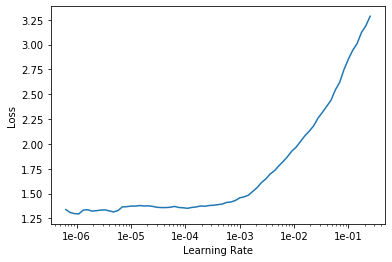

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, slice(1e-5, 0.01/5))

epoch,train_loss,valid_loss,error_rate,time
0,1.383072,1.147566,0.347783,02:37
1,1.289445,1.078049,0.331960,02:38
2,1.100505,0.972080,0.291742,02:38
3,0.889174,0.845440,0.258447,02:38
4,0.747727,0.821609,0.249217,02:38


In [90]:
def get_image_sizes(file_generator, store_array):
    max_0, max_1 = 0, 0
    for i, image_file in enumerate(file_generator):
        im = Image.open(image_file)
        size_0, size_1 = im.size
        store_array[i] = im.size_0 * im.size_1
        

train_jpg_gen = train_path.glob('**/*.jpg')
test_jpg_gen = test_path.glob('*.jpg')
sizes_test = np.zeros(test.items.shape)
sizes_train =  np.zeros( data.valid_ds.items.shape[0]  + data.train_ds.items.shape[0])
get_image_sizes(train_jpg_gen, sizes_train)
get_image_sizes(test_jpg_gen, sizes_test)

(array([1.400e+01, 4.240e+02, 3.256e+03, 4.017e+03, ..., 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([ 29.342802,  33.094   ,  36.845198,  40.596396, ..., 393.209012, 396.96021 , 400.711408, 404.462606]),
 <a list of 100 Patch objects>)

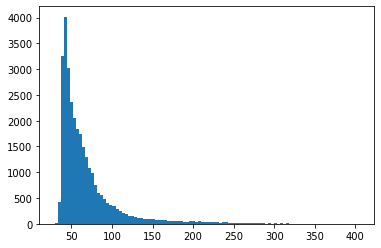

In [92]:
pl.hist(np.sqrt(sizes_train), bins=100)

In [22]:
learn.save('stage-2')

In [ ]:
learn.export(project_path/'export.pkl')

In [27]:
def make_and_send_submission(submission_name='submissionX',
                            submission_message='X submission'):
    df_sub = pd.read_csv(plankton_path/'sampleSubmission.csv')
    lexp = load_learner(project_path, test=test)
    images = [image.name for image in lexp.data.test_ds.items]
    preds, _ = lexp.get_preds(ds_type=DatasetType.Test)
    predictions = np.c_[images, preds.data]
    df_pred = pd.DataFrame(predictions, columns=df_sub.columns)
    df_pred.set_index('image', drop=True).to_csv(project_path/f'{submission_name}.csv')
    !kaggle competitions submit {competition} -f {project_path/f'{submission_name}.csv'} -m f"{submission_message}"

In [55]:
make_and_send_submission(submission_name='submission2.csv', submission_message='My second submission')

Traceback (most recent call last):
  File "/accounts/ekarakoy/anaconda3/envs/fastai/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/accounts/ekarakoy/anaconda3/envs/fastai/lib/python3.7/site-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/accounts/ekarakoy/anaconda3/envs/fastai/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 547, in competition_submit_cli
    competition, quiet)
  File "/accounts/ekarakoy/anaconda3/envs/fastai/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 498, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/accounts/ekarakoy/anaconda3/envs/fastai/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: '{project_path/f{submission_name}}'


In [58]:
!mv submission2.csv.csv submission2.csv

In [59]:
 !kaggle competitions submit {competition} -f {project_path/'submission2.csv'} -m "My second submission"

100%|████████████████████████████████████████| 205M/205M [00:05<00:00, 42.6MB/s]
Successfully submitted to National Data Science Bowl

The above scored 2.69, which is worse than the unfrozen version.

---
## TRAINING - PART 3
---

Here I load a different model, in this case

In [60]:
interp = ClassificationInterpretation.from_learner(learn)

In [63]:
conf_mat = interp.confusion_matrix()

/accounts/ekarakoy/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/train.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


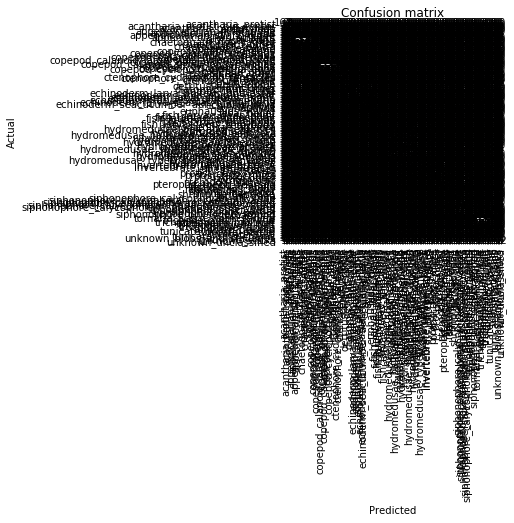

In [75]:
f1 = interp.plot_confusion_matrix(return_fig=True, slice_size=)

In [70]:
f1.savefig('confmat.png', dpi=300)

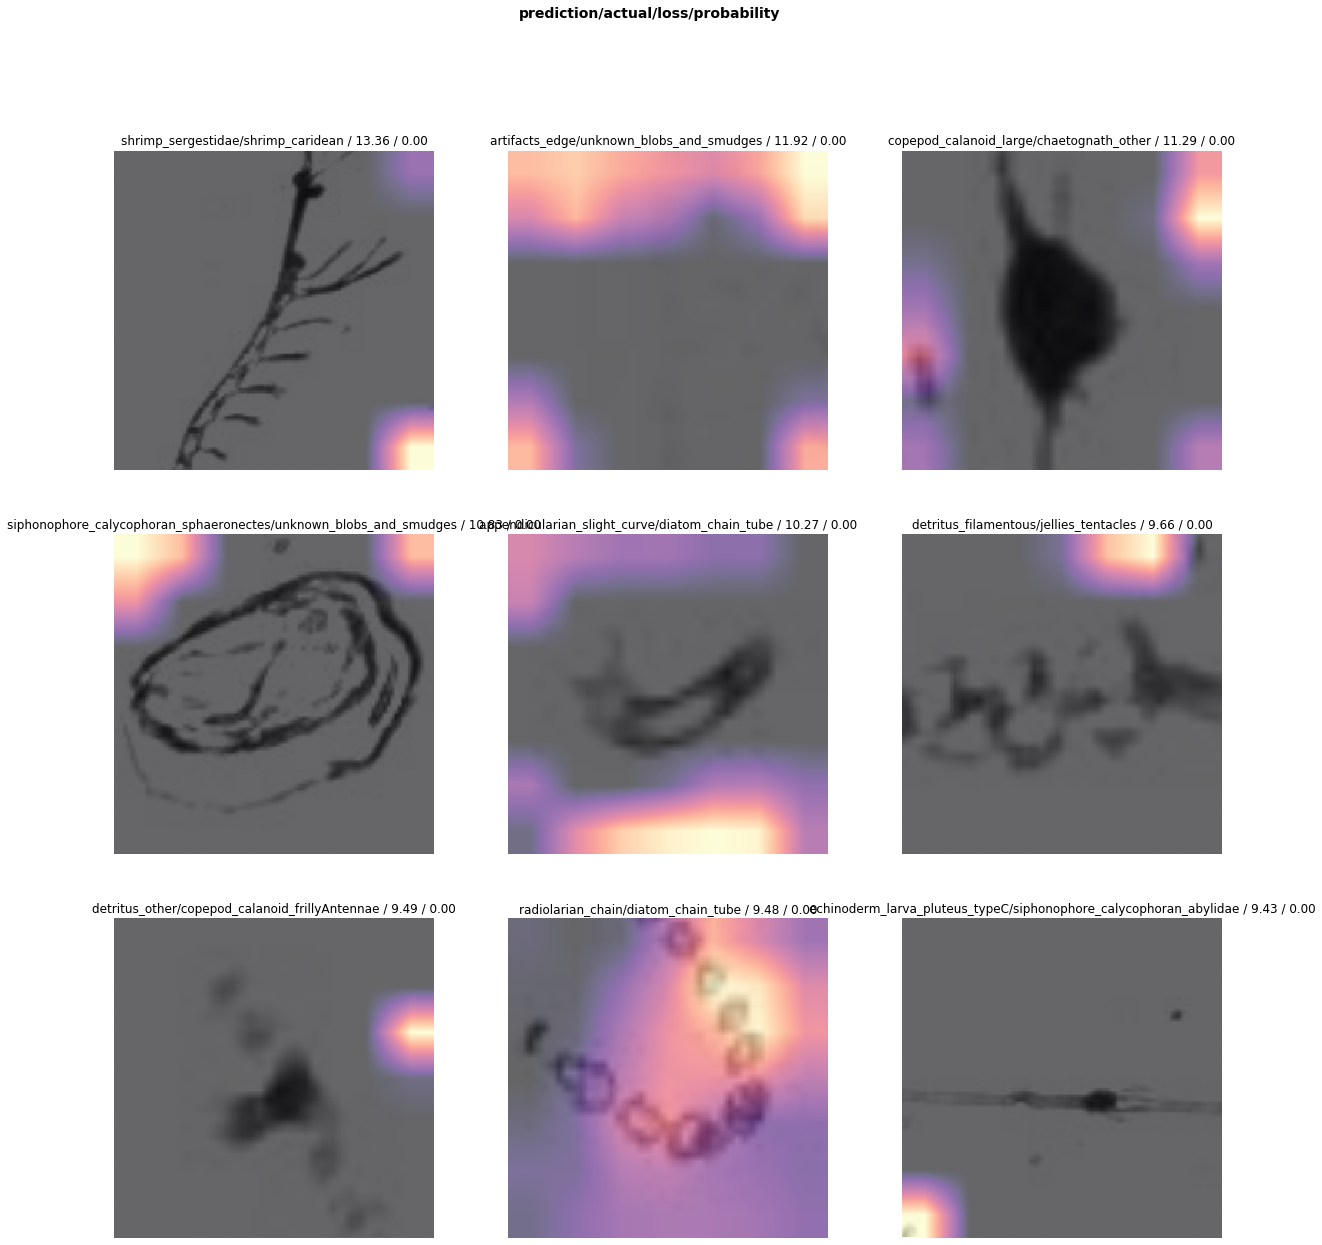

In [79]:
interp.plot_top_losses(9, figsize=(20, 20), heatmap=True)

In [64]:
import matplotlib.pyplot as pl
from seaborn import heatmap

In [ ]:
ax.set_xticklabels(data.classes)

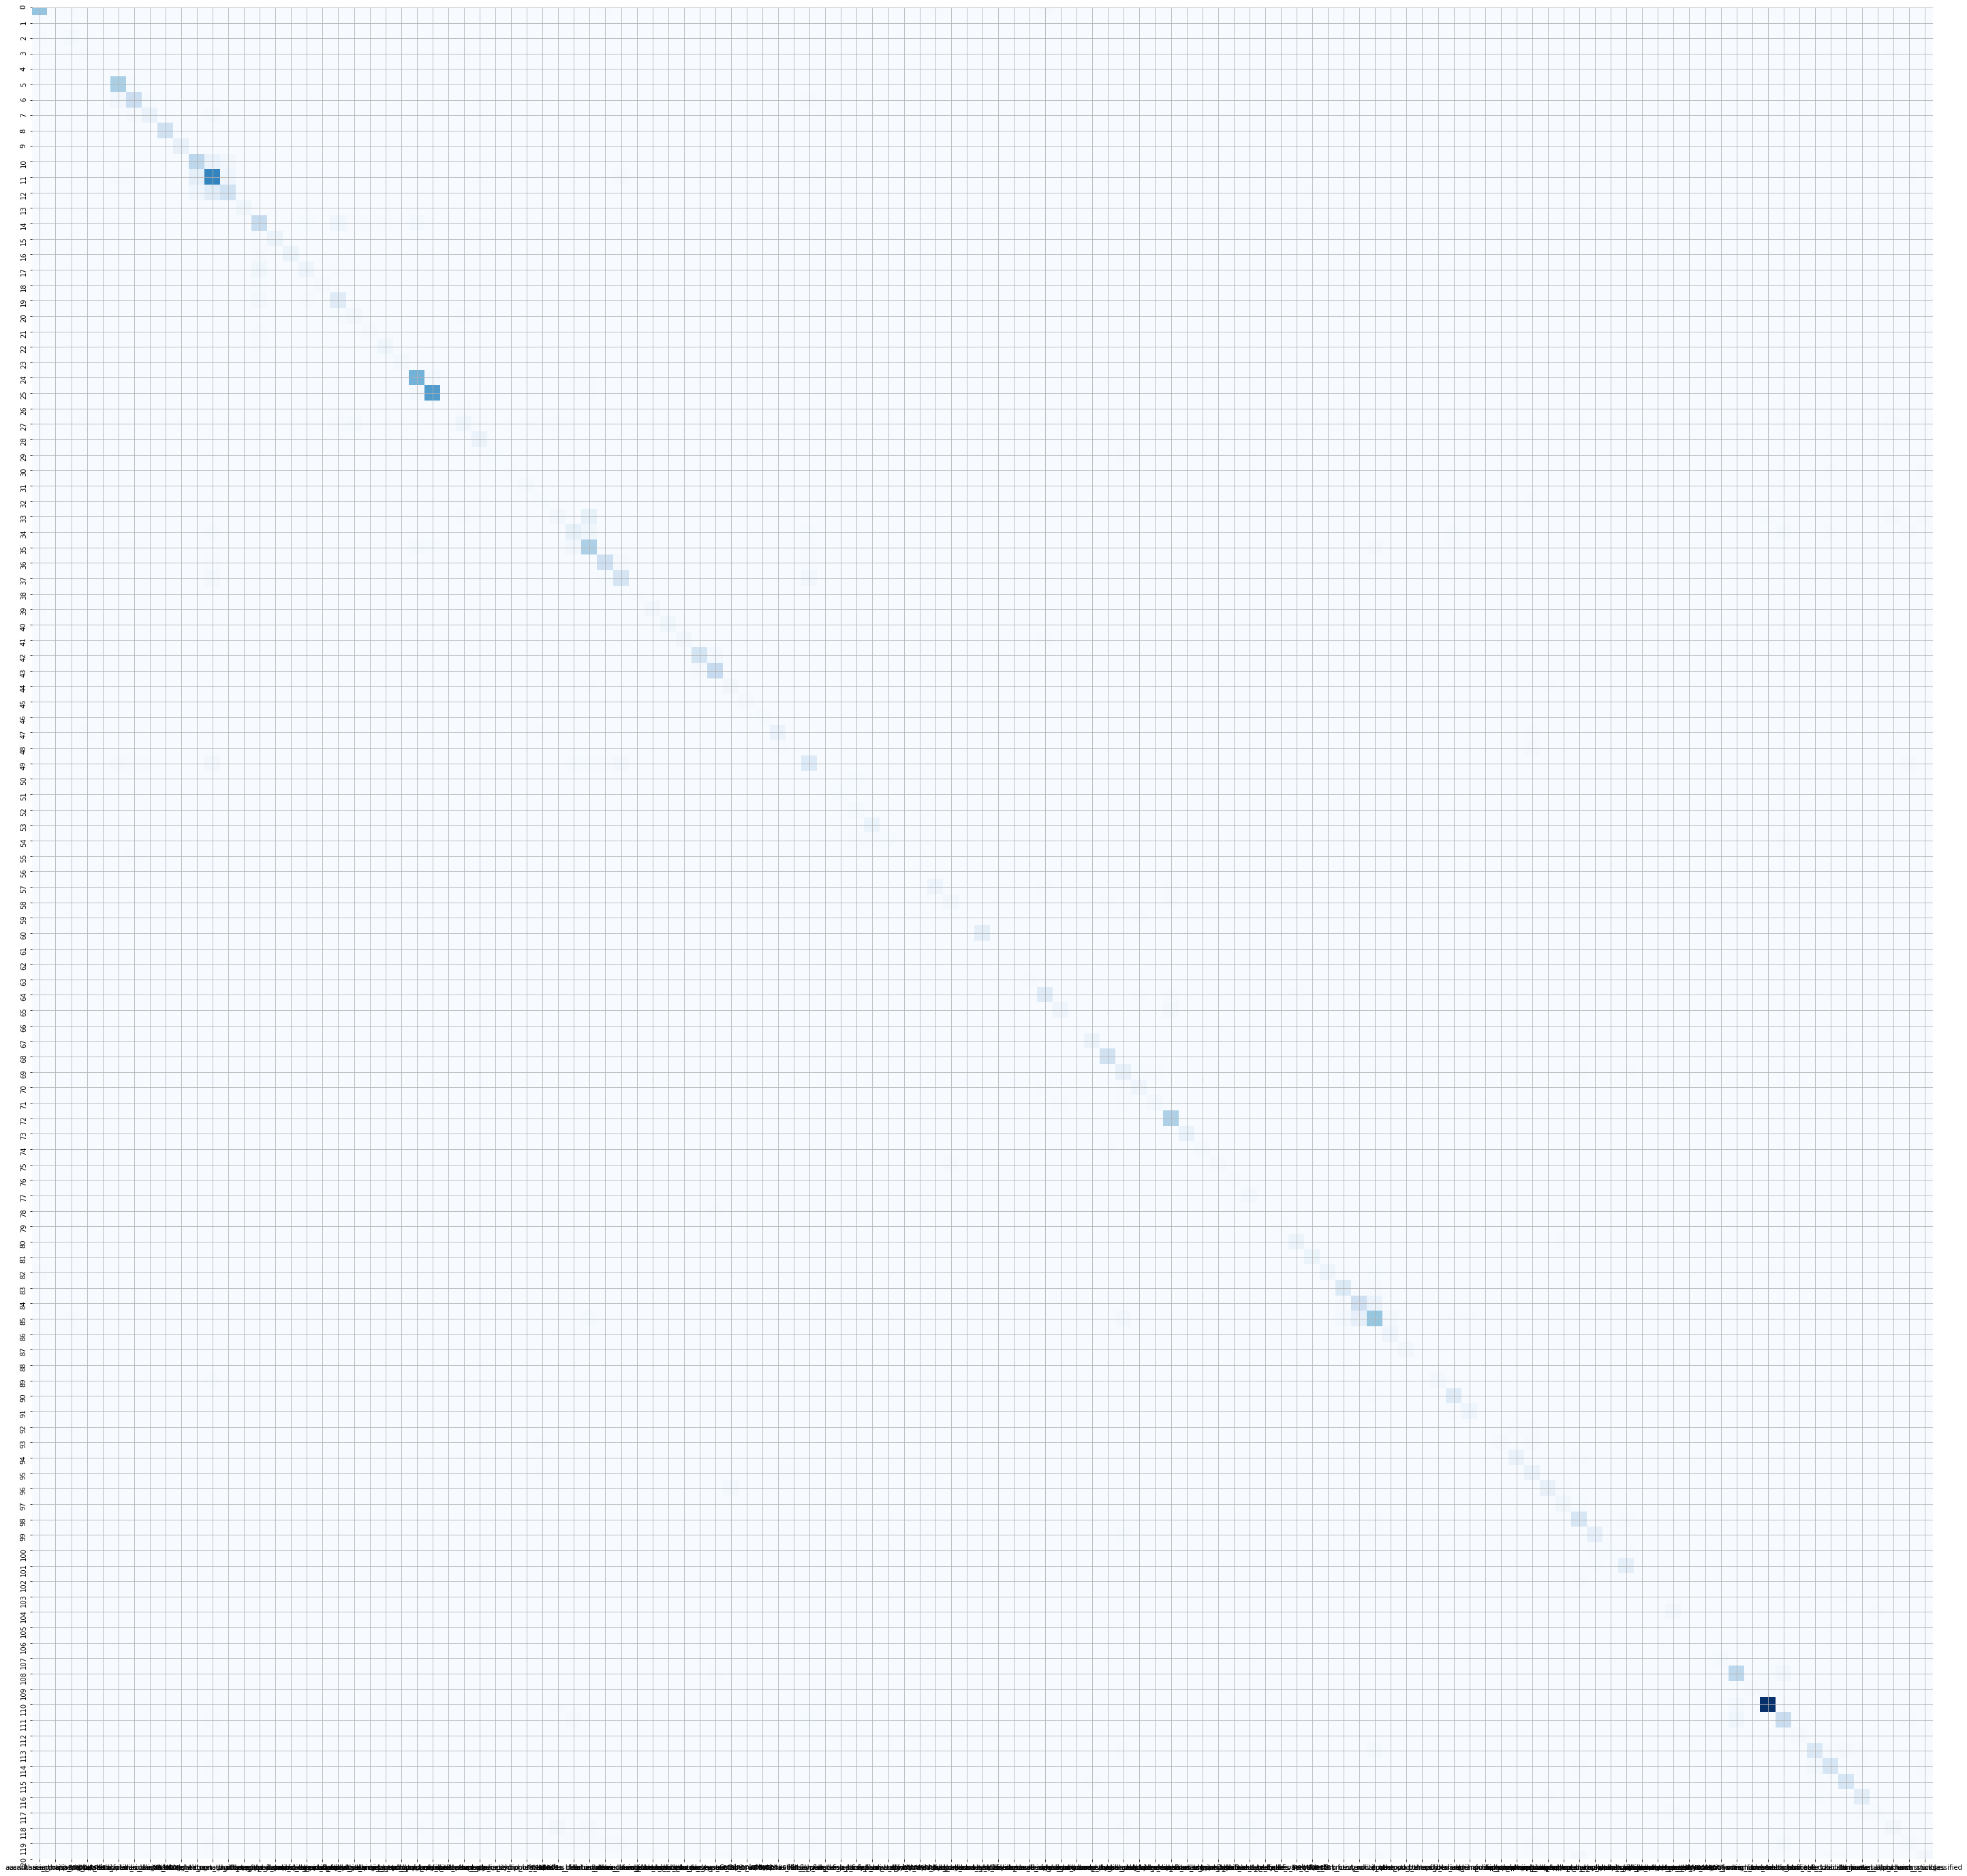

In [74]:
f, ax = pl.subplots(figsize=(50, 50))
heatmap(conf_mat, cmap='Blues', ax=ax, cbar=False)
ax.set_xticklabels(data.classes)
ax.grid()
f.savefig('confmat.png', dpi=300)

In [20]:
doc(ImageCleaner)

## Post learning data cleaning

ImageDeleter is essentially the same as the old FileDeleter.

ImageRelabeler renders the files you pass in and lets you re-label them. This is to find mis-categorized images in your data directory. NOTE: ImageRelabeler currently only works with files where labels were created from the names of their parent directory (i.e. with .from_folder()). The widget moves mislabeled photos from the incorrect parent directory to the properly-labeled parent directory.

To relabel an image, just click the proper label in the widget dropdown.

Both widgets take a formatted dataset from DatasetFormatter. You can easily specify which dataset you’d like to render by passing in DatasetType.Valid, DatasetType.Train or DatasetType.Test to the ds_type keyword arg in DatasetFormatter.from_toplosses.

All three classes are available in fastai.widgets.

In [65]:
doc(interp.plot_confusion_matrix)